In [1]:
import matplotlib.pyplot as plt
import numpy as np

DIMS = (16, 16)
NF = 2 # number of features / parameters

# random_result = np.random.randn(*DIMS)

# plt.imshow(random_result)
# plt.tight_layout()
# plt.show()

In [2]:
from functions import rastrigin

image = np.zeros(DIMS, dtype=float)

x = np.zeros(2)

i_space = np.linspace(-5.12, 5.12, DIMS[0])
j_space = np.linspace(-5.12, 5.12, DIMS[1])

for i, xi in enumerate(i_space):
    for j, xj in enumerate(j_space):
        x[0], x[1] = xi, xj
        image[i][j] = rastrigin(x)

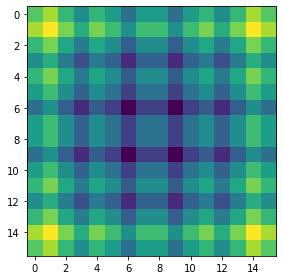

In [3]:
plt.imshow(image)
plt.tight_layout()
plt.show()

In [4]:
def sample_uniform(low, high, shape):
    return np.random.uniform(low, high, shape)


def evaluate(population, f=rastrigin):
    return np.apply_along_axis(f, 2, pop)


def plot_fitness(fitness):
    plt.imshow(fitness)
    plt.tight_layout()
    plt.show()

(16, 16)


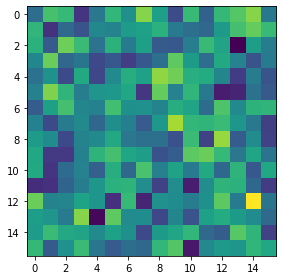

In [5]:
pop = sample_uniform(-5.12, 5.12, DIMS + (NF,))
fit = evaluate(pop)
print(fit.shape)
plot_fitness(fit)

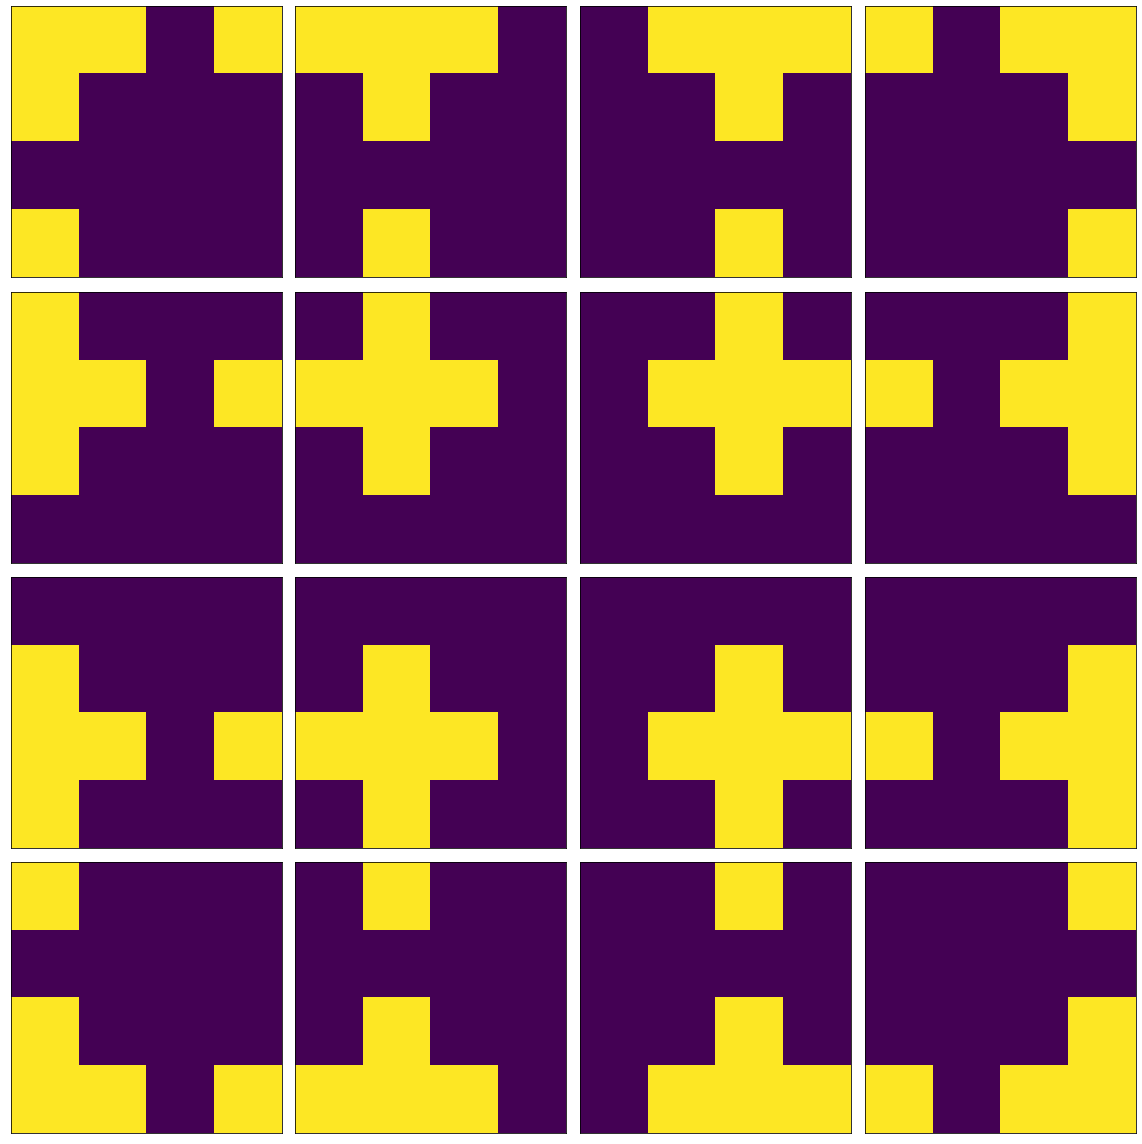

In [6]:
from operators import nhood_linear

def draw_nhood(image, nhood_idx):
    for idx in nhood_idx:
        x, y = idx
        image[x][y] = 1.0


fig, ax = plt.subplots(4, 4, figsize=(16, 16), subplot_kw={"xticks": (), "yticks": ()})

for i in range(4):
    for j in range(4):
        image = np.zeros((4, 4))
        nhood_idx = nhood_linear(i, j, (4, 4))
        draw_nhood(image, nhood_idx)
        ax[i][j].imshow(image)
fig.tight_layout()

In [8]:
from operators import nhood_get
from operators import recomb_singlepoint
from operators import select_linear

nhood_idx        = nhood_linear(0, 0, DIMS)
nhood, nhood_fit = nhood_get(pop, fit, nhood_idx)
print("nhood\n", nhood)

selected  = select_linear(nhood, nhood_fit)
nhood_new = np.zeros_like(nhood)
for i, (a, b) in enumerate(selected):
    c = recomb_singlepoint(nhood[a], nhood[b])
    nhood_new[i] = c

print("nhood_new\n", nhood_new)


nhood
 [[ 2.67367786  1.85380417]
 [ 1.44756886 -3.08566297]
 [-1.48825406  3.53870701]
 [ 2.80039277 -4.67465258]
 [ 3.27193859 -4.82660107]]
nhood_new
 [[ 3.27193859  1.85380417]
 [ 2.80039277 -4.82660107]
 [ 1.44756886  1.85380417]
 [ 3.27193859  1.85380417]
 [ 2.67367786 -3.08566297]]
